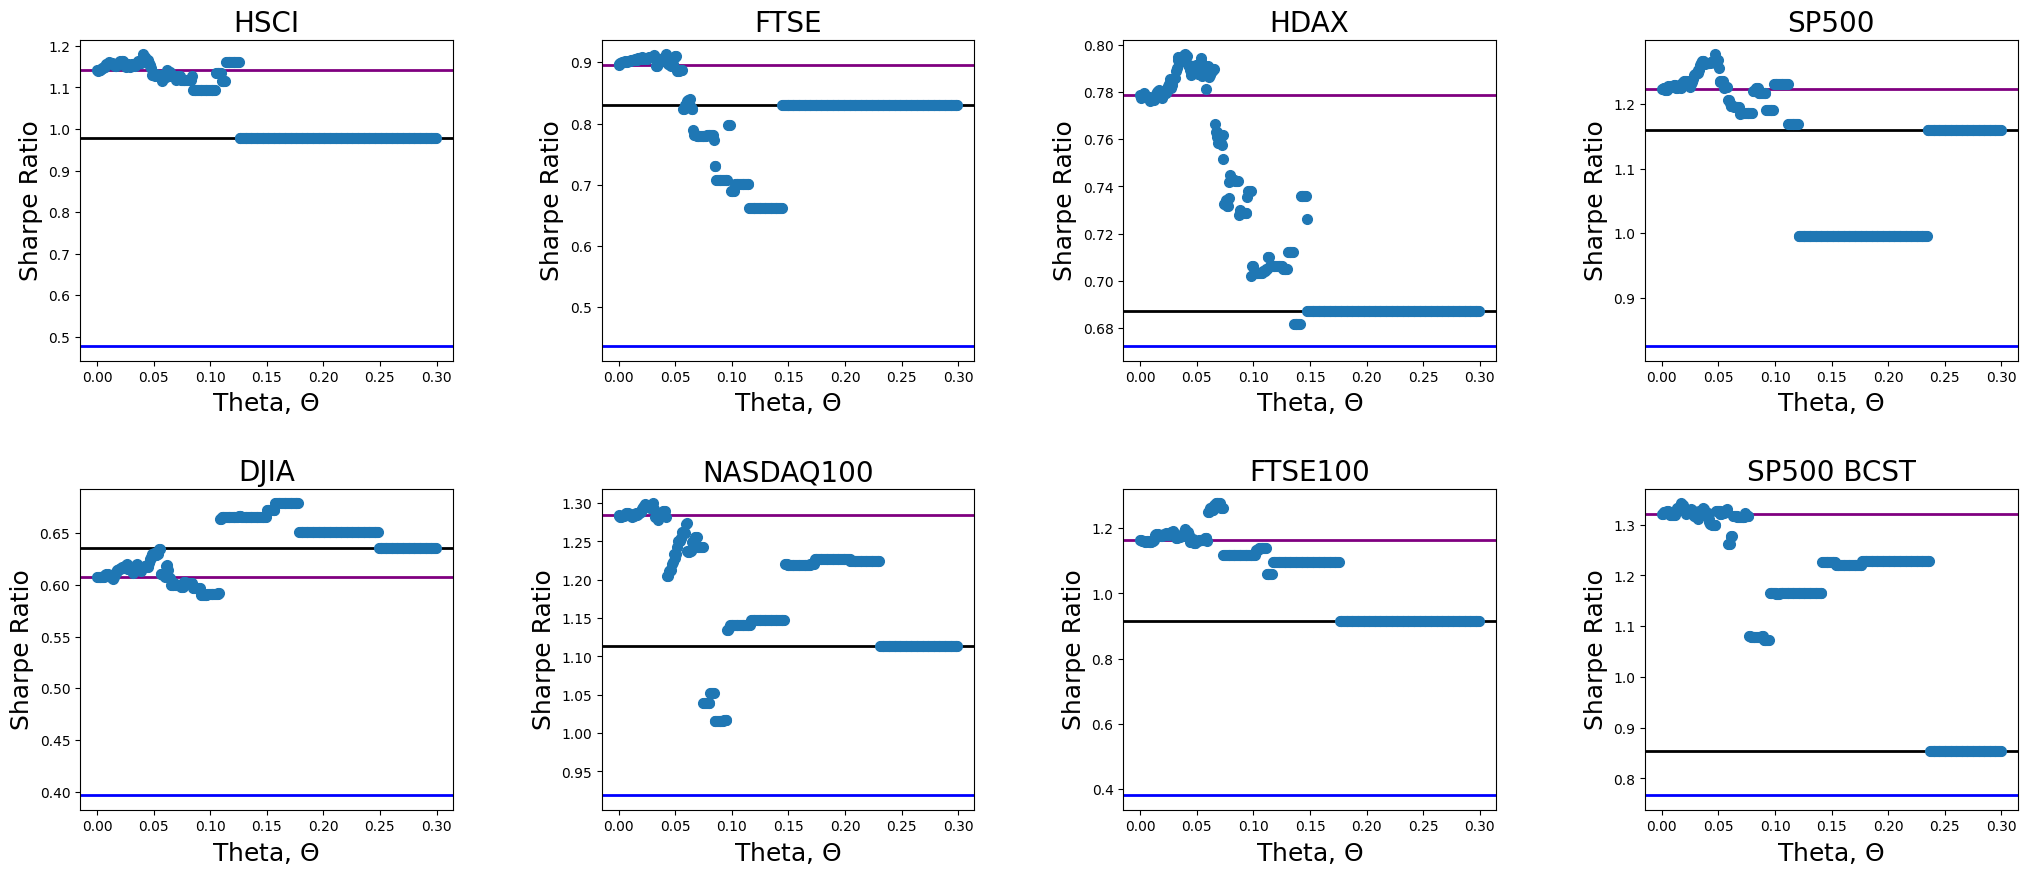

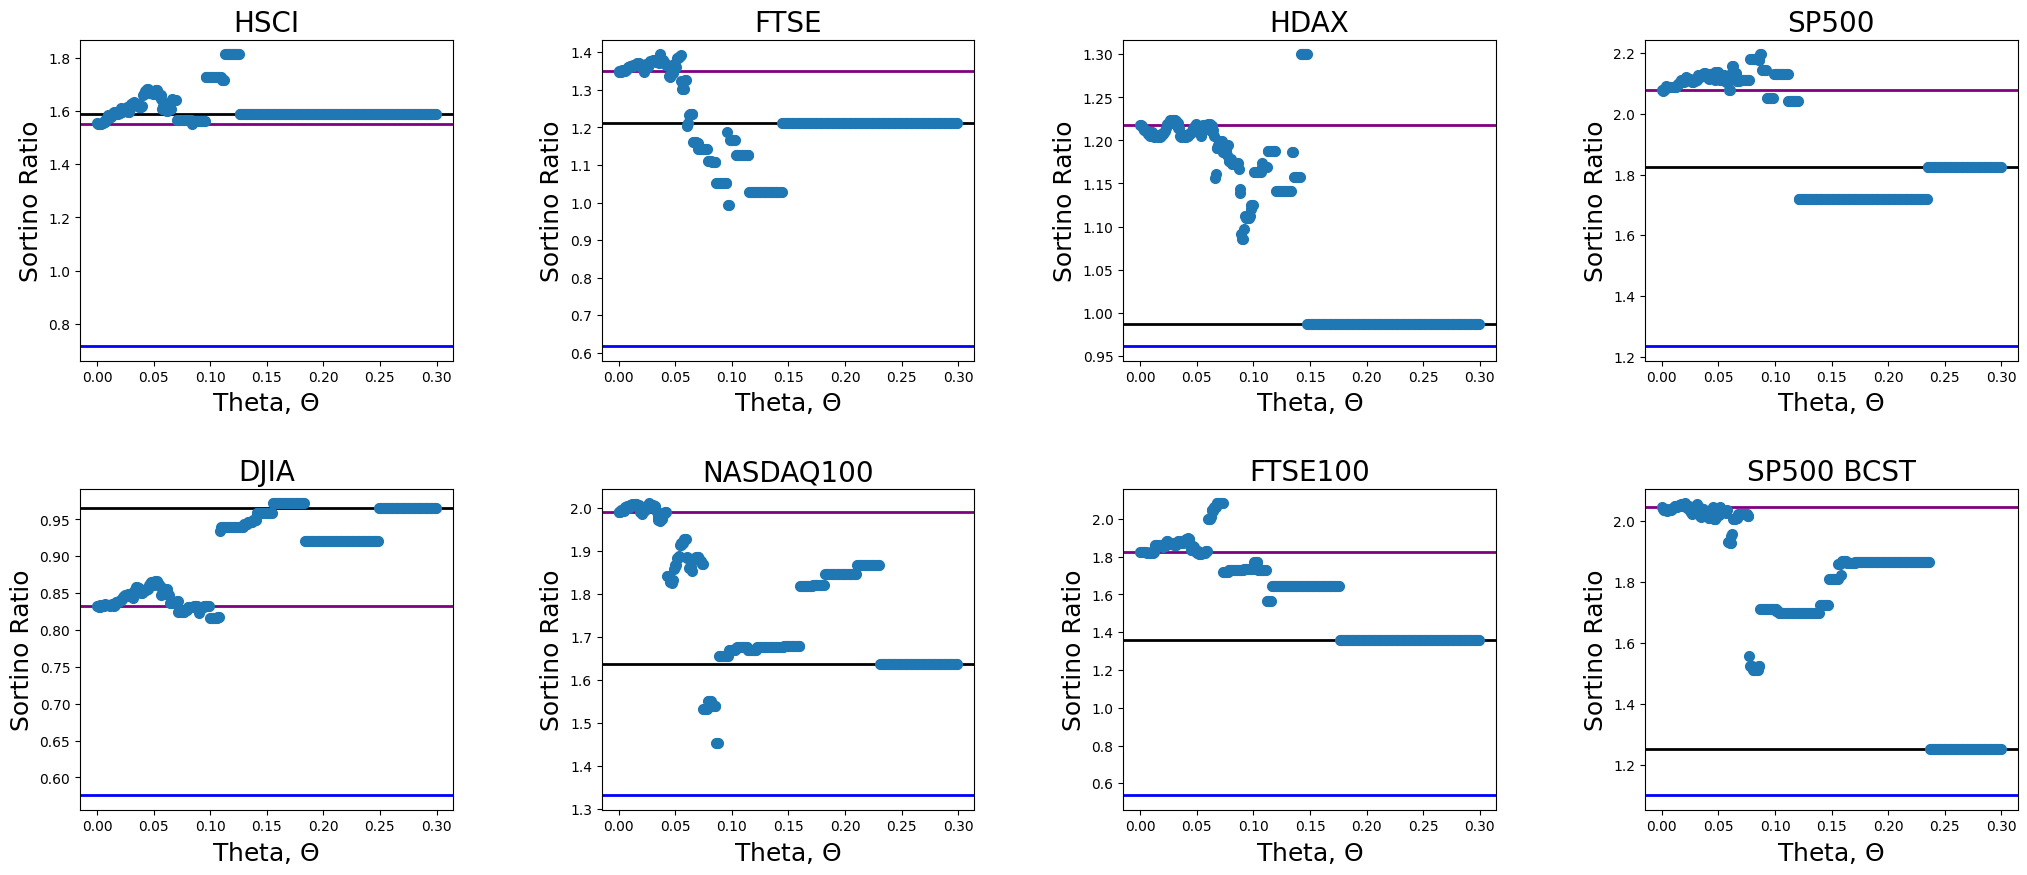

In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from pymongo import MongoClient


client = MongoClient(host="localhost", port=27017)
db = client.cno
runs = db.runs
event_types = ['DELTA_SUM_RETURN', 'DELTA_COV']

datasets = ['HSCI', 'FTSE', 'HDAX', 'SP500', 'DJIA', 'NASDAQ100', 'FTSE100', 'SP500_new']
NOTE = 'main'
return_type = 'SIMPLE'
objectives = ['SR', 'SoR']

for objective in objectives:

    fig = plt.figure(figsize=(25,10))
    gs = gridspec.GridSpec(ncols=4, nrows=2, figure=fig)

    for i, dataset in enumerate(datasets):
        ax = fig.add_subplot(gs[i])

        if dataset in ['FTSE', 'HSCI', 'HDAX', 'SP500']:
            ANNUAL_MULTIPLIER = np.sqrt(938/18)
        elif dataset == 'DJIA':
            ANNUAL_MULTIPLIER = np.sqrt(1362/26.25)
        elif dataset == 'NASDAQ100':
            ANNUAL_MULTIPLIER = np.sqrt(596/11.5)
        elif dataset == 'FTSE100':
            ANNUAL_MULTIPLIER = np.sqrt(716/13.83)
        elif dataset == 'SP500_new':
            ANNUAL_MULTIPLIER = np.sqrt(594/11.5)
        elif dataset == 'NASDAQComp':
                ANNUAL_MULTIPLIER = np.sqrt(684/13.25)

        if dataset == 'SP500_new':
            label = 'SP500 BCST'
        else:
            label = dataset

        filters = {
            'objective': objective,
            'dataset': dataset,
            'data_partition': 1/2,
            'note': NOTE,
        }

        filters['rebalancing_rule'] = 'DISABLE'
        ew_doc = runs.find_one(filters)
        ax.axhline(y=ew_doc['metric']*ANNUAL_MULTIPLIER, linestyle='-', linewidth=2, label= 'equally-weighted', color='black')

        filters['rebalancing_rule'] = 'INDEX'
        index_doc = runs.find_one(filters)
        if dataset not in ['DJIA', 'NASDAQ100', 'FTSE100', 'SP500_new']:
            ax.axhline(y=index_doc['metric']*ANNUAL_MULTIPLIER, linestyle='-', linewidth=2, label= f'Index reference', color='blue')
        else: 
            ax.axhline(y=index_doc['metric'], linestyle='-', linewidth=2, label= f'Index reference', color='blue')
        filters['rebalancing_rule'] = 'PERIODIC'
        every_week_doc = runs.find_one(filters)
        ax.axhline(y=every_week_doc['metric']*ANNUAL_MULTIPLIER, linewidth=2, label= f'Weekly', color='purple')

        theta_list = []
        metric_list = []
        filters['rebalancing_rule'] = 'EVENT'
        for doc in runs.find(filters, {"theta": 1, "metric": 1}).sort('theta'):
            theta_list.append(doc['theta'])
            metric_list.append(doc['metric']*ANNUAL_MULTIPLIER)
        ax.plot(theta_list, metric_list, 'o', markersize=7, label=f'event-triggered')

        ax.set_xlabel(r'Theta, $\Theta$', fontsize=18)
        ax.set_ylabel('Sharpe Ratio' if objective == 'SR' else 'Sortino Ratio', fontsize=18)
        # plt.tick_params(axis='both', which='major', labelsize=16)
        # plt.legend(loc='lower right')
        # plt.xlim([None,0.15])

        ax.set_title(label, fontsize=20)
    plt.subplots_adjust(hspace=0.4, wspace=0.4)
    plt.savefig(f'results/thetas_{objective}.eps', bbox_inches='tight')

%reset -f

### Table of results

In [ ]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from fractions import Fraction
from pymongo import MongoClient


pd.set_option("display.precision", 4)

client = MongoClient(host="localhost", port=27017)
db = client.cno
runs = db.runs

event_type = 'DELTA_SUM_RETURN'
return_type = 'SIMPLE'
datasets = ['HSCI', 'FTSE', 'HDAX', 'SP500', 'DJIA', 'NASDAQ100', 'FTSE100', 'SP500_new']
NOTE = 'main'

objectives = ['SR', 'SoR']

partition = 1/2
file_path = f'results/metrics_table.txt'
if os.path.exists(file_path):
    os.remove(file_path)

for objective in objectives:

    result_table = pd.DataFrame(np.nan,
        index=datasets,
        columns=['EW', 'MI', 'Weekly', 'ET-1', 'ET-2'])
    annualized_table = pd.DataFrame(np.nan,
        index=datasets,
        columns=['EW', 'MI', 'Weekly', 'ET-1', 'ET-2'])

    for dataset in datasets:

        if dataset in ['FTSE', 'HSCI', 'HDAX', 'SP500']:
            ANNUAL_MULTIPLIER = np.sqrt(938/18)
        elif dataset == 'DJIA':
            ANNUAL_MULTIPLIER = np.sqrt(1362/26.25)
        elif dataset == 'NASDAQ100':
            ANNUAL_MULTIPLIER = np.sqrt(596/11.5)
        elif dataset == 'FTSE100':
            ANNUAL_MULTIPLIER = np.sqrt(716/13.83)
        elif dataset == 'SP500_new':
            ANNUAL_MULTIPLIER = np.sqrt(594/11.5)
        elif dataset == 'NASDAQComp':
                ANNUAL_MULTIPLIER = np.sqrt(684/13.25)

        filters = {
            'objective': objective,
            'dataset': dataset,
            'data_partition': partition,
            'note': NOTE,
        }

        filters['rebalancing_rule'] = 'DISABLE'
        ew_doc = runs.find_one(filters)
        result_table.loc[dataset]['EW'] = ew_doc['metric_seq'][-1]*ANNUAL_MULTIPLIER
        annualized_table.loc[dataset]['EW'] = ew_doc['annualized_returns'][-1]

        filters['rebalancing_rule'] = 'INDEX'
        index_doc = runs.find_one(filters)
        if dataset not in ['DJIA', 'NASDAQ100', 'FTSE100', 'SP500_new']:
            result_table.loc[dataset]['MI'] = index_doc['metric_seq'][-1]*ANNUAL_MULTIPLIER
        else:
            result_table.loc[dataset]['MI'] = index_doc['metric_seq'][-1]
        annualized_table.loc[dataset]['MI'] = index_doc['annualized_returns'][-1]

        filters['rebalancing_rule'] = 'PERIODIC'
        every_week_doc = runs.find_one(filters)
        result_table.loc[dataset]['Weekly'] = every_week_doc['metric_seq'][-1]*ANNUAL_MULTIPLIER
        annualized_table.loc[dataset]['Weekly'] = every_week_doc['annualized_returns'][-1]

        filters['rebalancing_rule'] = 'EVENT'
        filters['event_type'] = {'$in': ['PORTFOLIO_RETURN_MU', 'PORTFOLIO_RETURN_RF']}
        event_doc = list(runs.find(filters).sort('metric', -1).limit(1))[0]
        result_table.loc[dataset]['ET-1'] = event_doc['metric_seq'][-1]*ANNUAL_MULTIPLIER
        annualized_table.loc[dataset]['ET-1'] = event_doc['annualized_returns'][-1]

        filters['event_type'] = 'DELTA_SUM_RETURN'
        event_doc = list(runs.find(filters).sort('metric', -1).limit(1))[0]
        result_table.loc[dataset]['ET-2'] = event_doc['metric_seq'][-1]*ANNUAL_MULTIPLIER
        annualized_table.loc[dataset]['ET-2'] = event_doc['annualized_returns'][-1]

    print(objective)
    print(result_table.to_latex())
    print(annualized_table.to_latex())

%reset -f

<h3>Dynamics of gamma</h3>

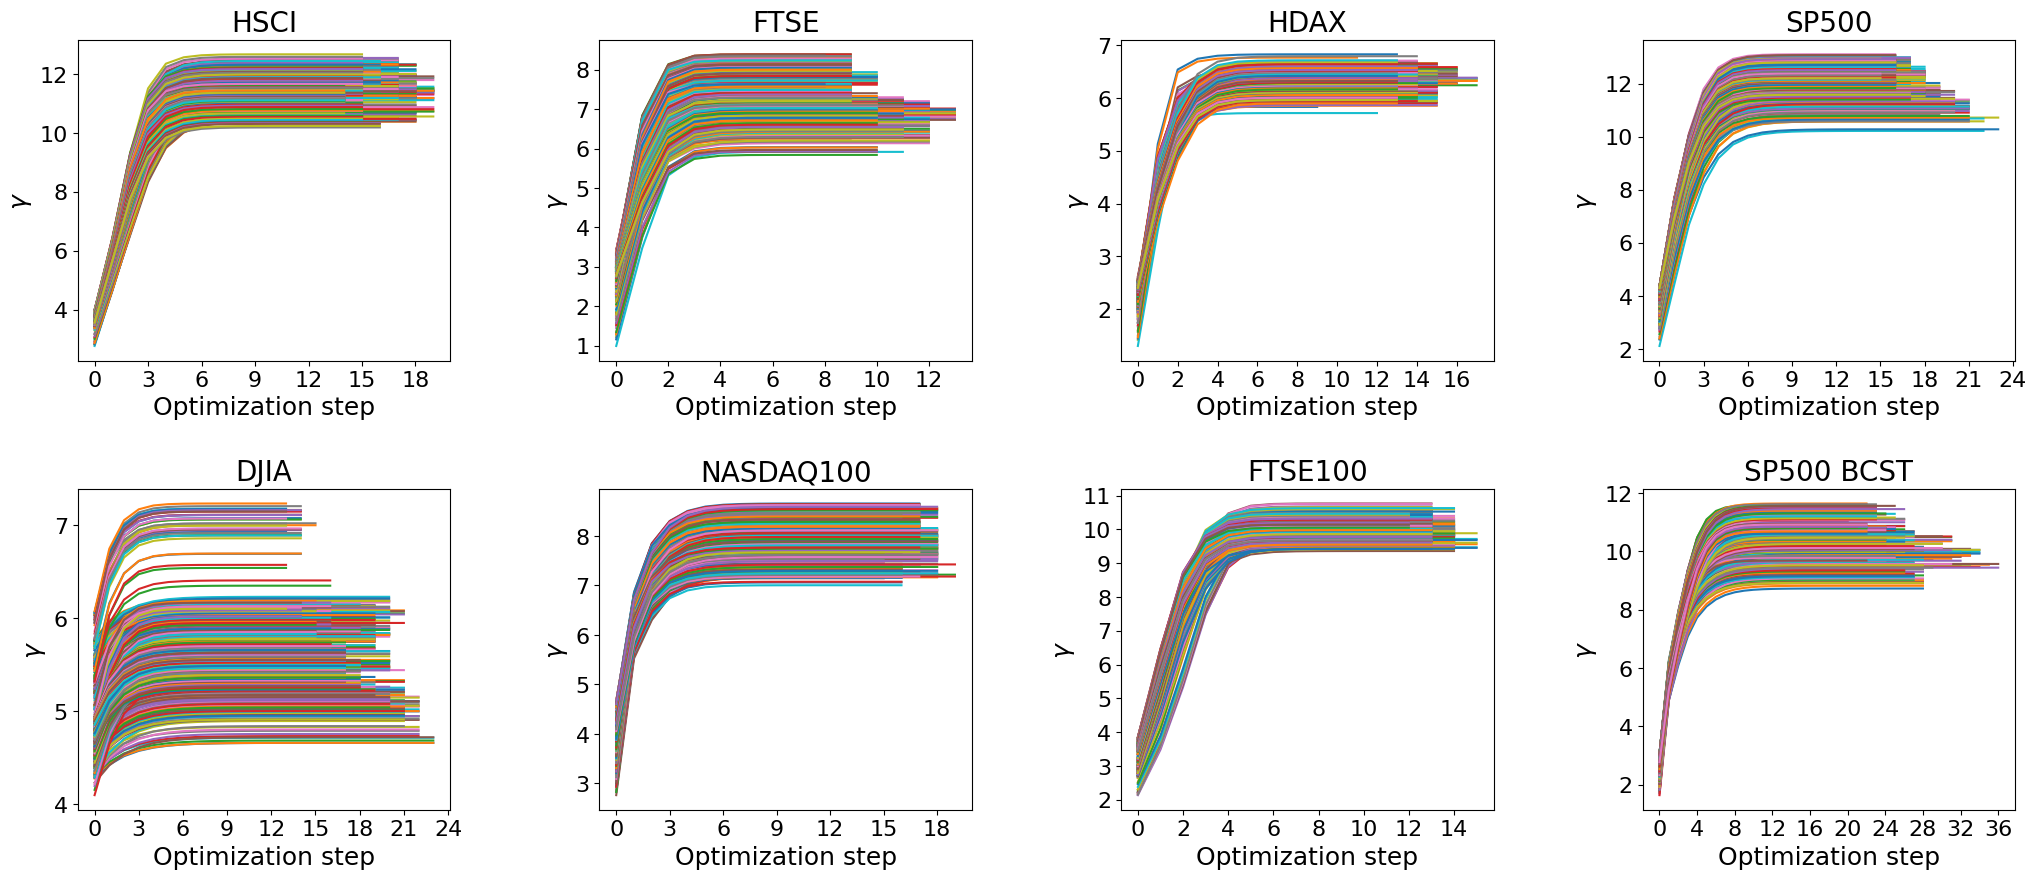

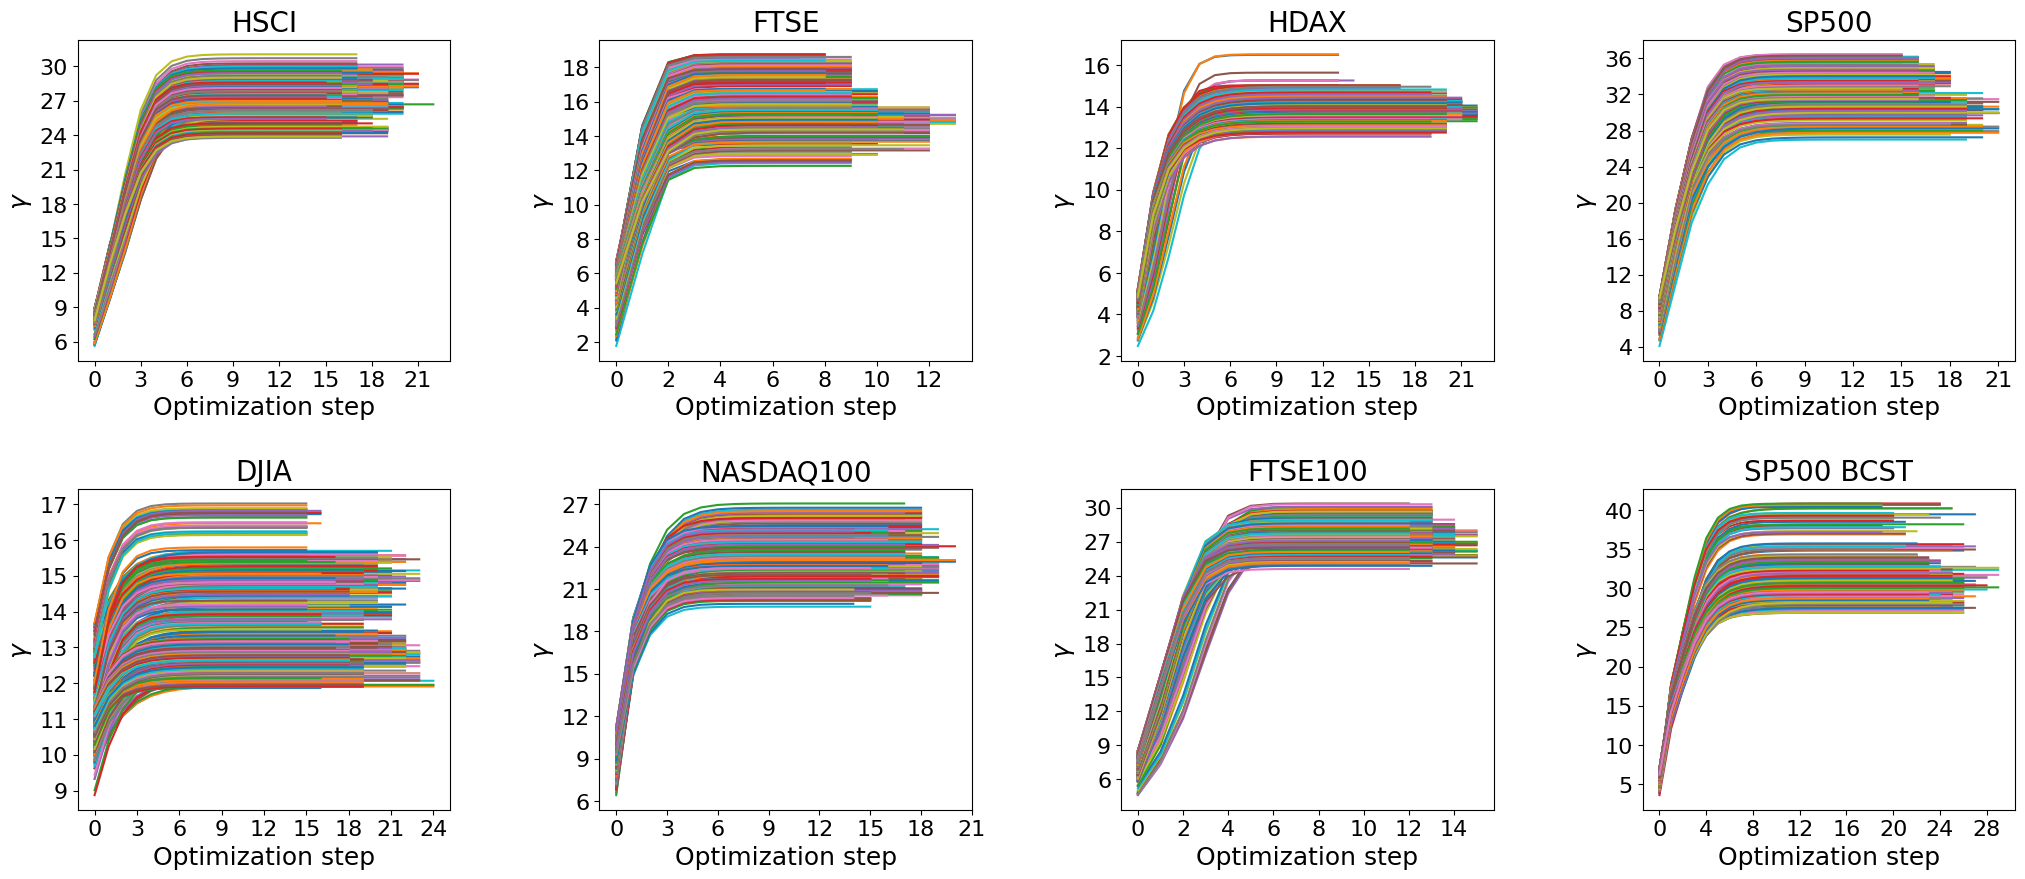

In [24]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
from pymongo import MongoClient
from matplotlib.ticker import MaxNLocator

client = MongoClient(host="localhost", port=27017)
db = client.cno
runs = db.runs

datasets = ['HSCI', 'FTSE', 'HDAX', 'SP500', 'DJIA', 'NASDAQ100', 'FTSE100', 'SP500_new']
NOTE = 'main'
objectives = ['SR', 'SoR']

for objective in objectives: 

    fig = plt.figure(figsize=(25,10))
    gs = gridspec.GridSpec(ncols=4, nrows=2, figure=fig)

    for i, dataset in enumerate(datasets):
        ax = fig.add_subplot(gs[i])

        if dataset == 'SP500_new':
            label = 'SP500 BCST'
        else:
            label = dataset

        data = runs.find({
            'objective': objective, 
            'rebalancing_rule': 'PERIODIC',
            'data_partition': 1/2,
            'dataset': dataset,
            'note': NOTE,
        }).sort('metric', -1).limit(1)

        data = list(data)[0]
        
        for _ in data['gamma_log']:
            ax.plot(_)
            ax.set_title(label, fontsize=20)
            ax.set_xlabel('Optimization step', fontsize=18)
            ax.set_ylabel(r'$\gamma$', fontsize=18)
            ax.tick_params(axis='both', which='major', labelsize=16)
            ax.xaxis.set_major_locator(MaxNLocator(integer=True))
            ax.yaxis.set_major_locator(MaxNLocator(integer=True))

    plt.subplots_adjust(hspace=0.4, wspace=0.4)
    plt.savefig(f'results/gamma_{objective}.eps', bbox_inches='tight')
%reset -f

468
469
470


ValueError: x and y must have same first dimension, but have shapes (428,) and (429,)

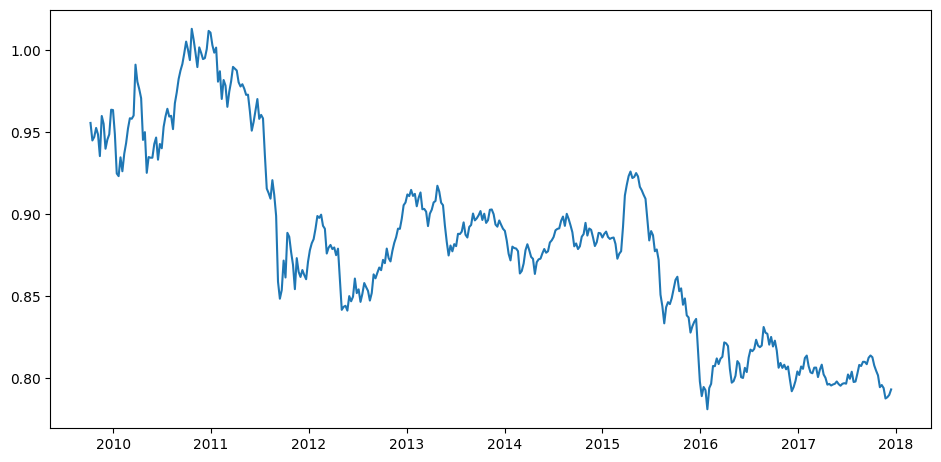

In [49]:
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.ticker import MaxNLocator
from pymongo import MongoClient


pd.set_option("display.precision", 4)

client = MongoClient(host="localhost", port=27017)
db = client.cno
runs = db.runs

objectives = ['SR', 'SoR']
datasets = ['HSCI', 'FTSE', 'HDAX', 'SP500', 'DJIA', 'NASDAQ100', 'FTSE100', 'SP500_new']
NOTE = 'main'
partition = 1/2
ANNUAL_MULTIPLYER = np.sqrt(938/18)
ESTIMATION_START = 469

for objective in objectives:

    fig = plt.figure(figsize=(25,25))
    gs = gridspec.GridSpec(ncols=2, nrows=4, figure=fig)

    for i, dataset in enumerate(datasets):
        ax = fig.add_subplot(gs[i])

        if dataset in ['FTSE', 'HSCI', 'HDAX', 'SP500']:
            ANNUAL_MULTIPLIER = np.sqrt(938/18)
            date_start = "2009-01-01"
        elif dataset == 'DJIA':
            ANNUAL_MULTIPLIER = np.sqrt(1362/26.25)
            date_start = "2003-04-01"
        elif dataset == 'NASDAQ100':
            ANNUAL_MULTIPLIER = np.sqrt(596/11.5)
            date_start = "2010-11-01"
        elif dataset == 'FTSE100':
            ANNUAL_MULTIPLIER = np.sqrt(716/13.83)
            date_start = "2009-07-01"
        elif dataset == 'SP500_new':
            ANNUAL_MULTIPLIER = np.sqrt(594/11.5)
            date_start = "2010-11-01"
        elif dataset == 'NASDAQComp':
            ANNUAL_MULTIPLIER = np.sqrt(684/13.25)

        filters = {
            'objective': objective,
            'dataset': dataset,
            'data_partition': partition,
            'note': NOTE,
        }

        if dataset == 'SP500_new':
            label = 'SP500 BCST'
        else:
            label = dataset

        filters['rebalancing_rule'] = 'DISABLE'
        ew_doc = runs.find_one(filters)

        filters['rebalancing_rule'] = 'INDEX'
        index_doc = runs.find_one(filters)

        filters['rebalancing_rule'] = 'PERIODIC'
        every_week_doc = runs.find_one(filters)

        filters['rebalancing_rule'] = 'EVENT'
        filters['event_type'] = {'$in': ['PORTFOLIO_RETURN_MU', 'PORTFOLIO_RETURN_RF']}
        event1_doc = list(runs.find(filters).sort('metric', -1).limit(1))[0]

        filters['event_type'] = 'DELTA_SUM_RETURN'
        event2_doc = list(runs.find(filters).sort('metric', -1).limit(1))[0]

        dates = []
        date_start = datetime.datetime.strptime(date_start,"%Y-%m-%d")
        for i in range(len(ew_doc['metric_ex_ante_seq'])):
            dates.append(date_start + datetime.timedelta(weeks=1*i))

        weeks_skip = 40
        ax.plot(dates[weeks_skip:], [ANNUAL_MULTIPLIER*e for e in  ew_doc['metric_ex_ante_seq'][weeks_skip:]], label='Equally-weighted')
        ax.plot(dates[weeks_skip:], [ANNUAL_MULTIPLIER*e for e in  event1_doc['metric_ex_ante_seq'][weeks_skip:]], linewidth=3, label='Event-triggered R')
        ax.plot(dates[weeks_skip:], [ANNUAL_MULTIPLIER*e for e in  event2_doc['metric_ex_ante_seq'][weeks_skip:]], linewidth=3, label=r'Event-triggered $\Delta$R')
        ax.plot(dates[weeks_skip:], [ANNUAL_MULTIPLIER*e for e in  every_week_doc['metric_ex_ante_seq'][weeks_skip:]], label='Every-week rebalancing')
        if dataset not in ['DJIA', 'NASDAQ100', 'FTSE100', 'SP500_new']:
            ax.plot(dates[weeks_skip:], [ANNUAL_MULTIPLIER*e for e in  index_doc['metric_ex_ante_seq'][weeks_skip:]], label='Market Index')
        else:
            ax.plot(dates[weeks_skip:], index_doc['metric_ex_ante_seq'][weeks_skip:], label='Market Index')
        ax.set_xlabel('Year', fontsize=18)
        ax.set_ylabel('Sharpe Ratio' if objective == 'SR' else 'Sortino Ratio', fontsize=18)
        ax.tick_params(axis='both', which='major', labelsize=16)
        ax.yaxis.set_major_locator(MaxNLocator(integer=True))
        ax.legend(fontsize=18)
        ax.set_title(label, fontsize=20)

    plt.subplots_adjust(hspace=0.4, wspace=0.2)
    plt.savefig(f'results/exante_{objective}.eps', bbox_inches='tight')

%reset -f